# Solving the Full Schrödinger Equation: A Tribute to Quantum Mechanics

### Authors: Ioannis Kalaitzidis, Edward Lopez, & Josue Ruiz (updated as of April 18 @ 7:31pm)

a) In this first section, we are going to calculate the ground state energy of an electron in a square potential well with infinitely high walls separated by a distance $L$ equal to the Bohr radius $a_0 = 5.2918 \times 10^{-11}m.$

Using the secant method:

In [7]:
from numpy import array, arange, zeros

# Constants
m = 9.1094e-31     # Mass of electron [kg]
hbar = 1.0546e-34  # Planck's constant over 2*pi [J*s]
e = 1.6022e-19     # Electron charge [C]
L = 5.2918e-11     # Bohr radius [m]
N = 1000
h = L/N

# Potential function
def V(x):
    return 0.0

# function to calculate TISE (time independent schrodinger equation)
def f(r,x,E):
    psi = r[0]
    phi = r[1]
    fpsi = phi
    fphi = (2*m/hbar**2)*(V(x)-E)*psi
    return array([fpsi,fphi],float)

# Calculate the wavefunction for a particular energy using 4th Order Runge-Kutta Method
def solve(E):
    psi = 0.0
    phi = 1.0
    r = array([psi,phi],float)

    for x in arange(0,L,h):
        k1 = h*f(r,x,E)
        k2 = h*f(r+0.5*k1,x+0.5*h,E)
        k3 = h*f(r+0.5*k2,x+0.5*h,E)
        k4 = h*f(r+k3,x+h,E)
        r += (k1+2*k2+2*k3+k4)/6

    return r[0]

# Main program to find the energy using the secant method
E1 = 0.0
E2 = e
psi2 = solve(E1)

target = e/1000
while abs(E1-E2)>target:
    psi1,psi2 = psi2,solve(E2)
    E1,E2 = E2,E2-psi2*(E2-E1)/(psi2-psi1)

print("E (ground state) =",E2/e,"eV.")

E (ground state) = 134.28637169369105 eV.


b) For instance, suppose the potential inside the well is nonzero but varies as $V(x)=V_0\frac{x}{L}(\frac{x}{L}-1),$ where $V_0 = 260$ eV. It's straightforward to solve for the ground-state energy of this problem also. Just a matter of changing the function for $V(x)$, thus:

In [8]:
from numpy import array, arange

# Constants
m = 9.1094e-31     # Mass of electron [kg]
hbar = 1.0546e-34  # Planck's constant over 2*pi [J*s]
e = 1.6022e-19     # Electron charge [C]
L = 5.2918e-11     # Bohr radius [m]
N = 1000
h = L/N

# New potential function (non zero, now it is a function of x)
VO = 260*e
def V(x):
    return VO*(x/L)*(x/L-1)

# New function to solve TISE, outputs an array with energy eigenvalues and eigen functions
def f(r,x,E):
    psi = r[0]
    phi = r[1]
    fpsi = phi
    fphi = (2*m/hbar**2)*(V(x)-E)*psi
    return array([fpsi,fphi],float)

# Calculate the wavefunction for a particular energy, again utilizing 4th order runge-kutta method
def solve(E):
    psi = 0.0
    phi = 1.0
    r = array([psi,phi],float)

    for x in arange(0,L,h):
        k1 = h*f(r,x,E)
        k2 = h*f(r+0.5*k1,x+0.5*h,E)
        k3 = h*f(r+0.5*k2,x+0.5*h,E)
        k4 = h*f(r+k3,x+h,E)
        r += (k1+2*k2+2*k3+k4)/6

    return r[0]

# Main program to find the energy using the secant method
E1 = 0.0
E2 = e
psi2 = solve(E1)

target = e/1000
while abs(E1-E2)>target:
    psi1,psi2 = psi2,solve(E2)
    E1,E2 = E2,E2-psi2*(E2-E1)/(psi2-psi1)

print("E (ground state) =",E2/e,"eV.")

E (ground state) = 77.69045100841701 eV.


c) Above and in class, we've dealt with the time-independent version of Schrödinger's equation. Now, we'll introduce what's called the Crank-Nicolson method to solve the full time-dependent Schrödinger equation and hence develop a picture of how a wavefunction evolves over time.

For simplicity, let's stick with one dimension and put our particle in a box with impenetrable walls. We only have to solve the equation in a finite-sized space, and the box forces the wavefunction to be zero at the walls. We'll put these walls at $x = 0$ and $x = L.$

Below is a cell for the tridiagonal version of Gaussian elimination that we'll be using in our primary code.

In [9]:
from __future__ import division, print_function
from numpy import copy

# Tridiagonal version of Gaussian elimination
def banded(Aa,va,up,down):

    # Copy the inputs and determine the size of system
    A = copy(Aa)
    v = copy(va)
    N = len(v)

    # Gaussian elimination
    for m in range(N):

        # Normalization factor
        div = A[up,m]

        # Update the vector first
        v[m] /= div
        for k in range(1,down+1):
            if m+k<N:
                v[m+k] -= A[up+k,m]*v[m]

        # Normalize the pivot row of A and subtract from lower ones
        for i in range(up):
            j = m + up - i
            if j<N:
                A[i,j] /= div
                for k in range(1,down+1):
                    A[i+k,j] -= A[up+k,m]*A[i,j]

    # Back substitution
    for m in range(N-2,-1,-1):
        for i in range(up):
            j = m + up - i
            if j<N:
                v[m] -= A[i,j]*v[j]

    return v

d) We can get the Crank-Nicolson equation for the Schrödinger equation by 1) replacing the second derivative of the Schrödinger equation with a finite difference, applying Euler's method, and 2) doing this again but in reverse. Taking the average of the two resulting equations, we get the Crank-Nicolson equation for the Schrödinger equation.

$$\psi(x, t+h)-h\frac{i\hbar}{4ma^{^{2}}}[\psi(x+a, t+h)+\psi(x-a, t+h)-2\psi(x, t+h)]=\psi(x,t)+h\frac{i\hbar}{4ma^{^{2}}}[\psi(x+a, t)+\psi(x-a, t)-2\psi(x,t)]$$

This gives us a set of simultaneous equations, one for each grid point ($a, 2a, 3a$, and so forth). Then, the Crank-Nicolson equations can be written in the form $$\mathbf{A}\psi(t+h)=\mathbf{B}\psi(t)$$

where $$\mathbf{A}=\begin{pmatrix}
 a_{1}  &  a_{2}  &  \\ 
 a_{2}  &  a_{1}  &  a_{2}  \\ 
 &  a_{2}  &  a_{1}  &  a_{2}  &  &  \\ 
 &  &  a_{2}  &  a_{1} \\ 
 &  &  &  & \ddots  
\end{pmatrix}$$ and $$\mathbf{B}=\begin{pmatrix}
 b_{1}  &  b_{2}  &  \\ 
 b_{2}  &  b_{1}  &  b_{2}  \\ 
 &  b_{2}  &  b_{1}  &  b_{2}  &  &  \\ 
 &  &  b_{2}  &  b_{1} \\ 
 &  &  &  & \ddots  
\end{pmatrix}.$$ with $$a_{1}=1+h\frac{i\hbar}{2ma^{2}},$$
$$a_{2}=-h\frac{i\hbar}{4ma^{2}},$$
$$b_{1}=1-h\frac{i\hbar}{2ma^{2}},$$ and
$$b_{2}=h\frac{i\hbar}{4ma^{2}}.$$

The equation $\mathbf{A}\psi(t+h)=\mathbf{B}\psi(t)$ has precisely the form $\mathbf{A}\mathbf{x}=\boldsymbol{v}$.

Now, let's consider an electron in a box of length $L=10^{-8}$m. Let's set the wavefunction of the electron at $t=0$ to have the form:$$\psi(x,0)=\exp[{-\frac{(x-x_{0})^{2}}{2\sigma^{2}}}]e^{i \kappa x},$$ where $$x_{0}=\frac{L}{2},$$ $$\sigma = 1 \times 10^{-10}m,$$ and $$\kappa = 5 \times 10^{10}m^{-1}.$$

Finally, we'll perform a single step of the Crank-Nicolson method for this electron, calculating the values of the wavefunction $\psi(t)$, given the initial wavefunction above and using $ N = 1000 $ spatial slices with $ a = L/N.$

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


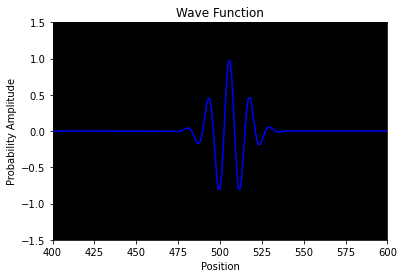

In [10]:
from __future__ import division, print_function
from os import sys
sys.path.append('cpresources')
from pylab import *
from numpy import *
import matplotlib.pyplot as plt

# Constants
h = 1e-18*10
hbar = 1.0546e-36
L = 1e-8
M = 9.109e-31
N = 1000 # Grid slices

a = L/N # Grid points

# Coefficients
a1 = 1 + h*hbar/2/M/a**2*1j
a2 = -h*hbar*1j/4/M/a**2
b1 =  1 - h*hbar/2/M/a**2*1j
b2 =  h*hbar*1j/4/M/a**2

# Initializing values for the wavefunction
ksi = zeros(N+1,complex)

def ksi0(x):
    x0 = L/2
    sigma = 1e-10
    k = 5e10
    return exp(-(x-x0)**2/2/sigma**2)*exp(1j*k*x)

x = linspace(0,L,N+1)
ksi[:] = ksi0(x)
ksi[[0,N]]=0

A = empty((3,N),complex)

A[0,:] = a2
A[1,:] = a1
A[2:,] = a2

# Solving for values of the wavefunction
for i in range(100):
    v = b1*ksi[1:N] + b2*(ksi[2:N+1] + ksi[0:N-1])
    ksi[1:N] = banded(A,v,1,1)

plot(ksi, color="blue")
ax = plt.gca()
ax.set_facecolor("black")
plt.xlim(400, 600)
plt.ylim(-1.5, 1.5)
title("Wave Function")
xlabel("Position")
ylabel("Probability Amplitude")

Ap = zeros((N-1,N-1),complex)
for i in range(N-2):
    Ap[i,i] = a2
    Ap[i+1,i] = a1 # Bottom
    Ap[i,i+1] = a1 # Right
Ap[N-2,N-2] = a2

Text(0, 0.5, 'Probability Density')

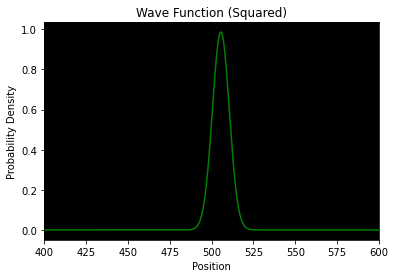

In [11]:
import matplotlib.pyplot as plt

# Calculating probability density from amplitude above
cj_values = conj(ksi)
density_values = cj_values*ksi
magnitude_ksi = abs(density_values)
magnitude_ksi_2 = magnitude_ksi*magnitude_ksi
plot(magnitude_ksi_2, color="green")
ax = plt.gca()
ax.set_facecolor("black")
plt.xlim(400, 600)
title("Wave Function (Squared)")
xlabel("Position")
ylabel("Probability Density")

## Part II: Surface Plot of Particle in 1D Box 

In [12]:
# First: Find Ground State 
from numpy import sin, linspace, zeros, exp, cos, array, arange, pi
from pylab import plot, xlabel, ylabel, show, legend
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np


# constants 
m = 9.1094e-31                 # mass of the electron
hbar = 1.0546e-34              # Planck constant / 2 pi
e = 1.6022e-19                 # electron charge
L = 5.2918e-11                 # Bohr radius

N = 1000                       # number of steps
h = L/N                        # step size
target = 1e-4


# Potential function
V0 = 0*e
def V(x):
    return V0*(x/L)*(x/L - 1)

# Function that returns array for dpsi/dx and dphi/dx
def f(r,x,E):
    psi = r[0]
    phi = r[1]
    fpsi = phi
    fphi = (2*m/hbar**2)*(V(x)-E)*psi
    return array([fpsi, fphi], float)

# Calculate the wavefunction for a particular energy
def solve(E):
    psi = 0.0
    phi = 1.0
    r = array([psi, phi], float)
    for x in arange(0,L,h):
        k1 = h*f(r, x, E)                   
        k2 = h*f(r + k1/2, x + h/2, E)
        k3 = h*f(r + k2/2, x + h/2, E)
        k4 = h*f(r + k3, x + h, E)       
        r += 1/6*(k1 + 2*k2 + 2*k3 + k4)
    return r[0]


def plotWavefunction(E):
    r = array([0, e], float)
    psiList = []
    for x in arange(0,L,h):
        psiList.append(r[0])
        k1 = h*f(r, x, E)                   
        k2 = h*f(r + k1/2, x + h/2, E)
        k3 = h*f(r + k2/2, x + h/2, E)
        k4 = h*f(r + k3, x + h, E)       
        r += 1/6*(k1 + 2*k2 + 2*k3 + k4)
    return psiList


# Find the Ground State, First and Second Excited States

for n in [1,2,3]:
    print("n =",n," gives E = ", n**2*pi**2*hbar**2/(2*m*L**2*e), "eV")


#Need to find energy s.t. wavefunction is zero at x=L, so 
# Use Newton's method (secant version) to solve psi(E)=0 for E
E1 = 0
E2 = 2e-17
p1, p2 = solve(E1), solve(E2)

while abs(E2-E1)>e/1000:
    E1, E2 = E2, E2 - p2*(E2-E1)/(p2 - p1)
    p1, p2 = solve(E1), solve(E2)
    
Eground = E2
print("Ground state energy = ", Eground/e, "eV")

#Need to find energy s.t. wavefunction is zero at x=L, so 
# Use Newton's method (secant version) to solve psi(E)=0 for E

E1 = 400*e
E2 = 500*e
p1, p2 = solve(E1), solve(E2)
while abs(E2-E1)>e/1000:
    E1, E2 = E2, E2 - p2*(E2-E1)/(p2 - p1)
    p1, p2 = solve(E1), solve(E2)
Ex1 = E2
print("Exited state 1 energy = ", E2/e, "eV")
    
E1 = 1000*e
E2 = 1100*e
p1, p2 = solve(E1), solve(E2)
while abs(E2-E1)>e/1000:
    E1, E2 = E2, E2 - p2*(E2-E1)/(p2 - p1)
    p1, p2 = solve(E1), solve(E2)
Ex2 = E2
print("Exited state 2 energy = ", E2/e, "eV")

n = 1  gives E =  134.28637170133268 eV
n = 2  gives E =  537.1454868053307 eV
n = 3  gives E =  1208.5773453119941 eV
Ground state energy =  134.2863717012906 eV
Exited state 1 energy =  537.1454867761507 eV
Exited state 2 energy =  1208.5773455532917 eV


In [13]:
# First: Calculate Dimentions of Wave Functions
from numpy import shape

def graphWF(Estate):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data
    wfarray = zeros((1000,1000))
    wfArray = array(plotWavefunction(Estate))
    wfarray[:,:] += wfArray 
    
    print("shape of wf data: ",shape(wfArray))

    bestX = zeros((1000,1000))
    bestY = zeros((1000,1000))

    storedValues = arange(0,L,h)
    print("this is stored values",shape(storedValues))

    for n in range(1000):
        bestX[n,:] += storedValues
        bestY[n,:] += storedValues - n*L


    # Plot the surface.
    surf = ax.plot_surface(bestX, bestY, wfarray, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    print(bestX)
    print(bestY)
    print(wfarray)

    # Customize the z axis.
    #ax.set_zlim(-3e-30, 3e-30)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    #ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5, location = 'left')

    plt.show()

shape of wf data:  (1000,)
this is stored values (1000,)
[[0.0000000e+00 5.2918000e-14 1.0583600e-13 ... 5.2759246e-11
  5.2812164e-11 5.2865082e-11]
 [0.0000000e+00 5.2918000e-14 1.0583600e-13 ... 5.2759246e-11
  5.2812164e-11 5.2865082e-11]
 [0.0000000e+00 5.2918000e-14 1.0583600e-13 ... 5.2759246e-11
  5.2812164e-11 5.2865082e-11]
 ...
 [0.0000000e+00 5.2918000e-14 1.0583600e-13 ... 5.2759246e-11
  5.2812164e-11 5.2865082e-11]
 [0.0000000e+00 5.2918000e-14 1.0583600e-13 ... 5.2759246e-11
  5.2812164e-11 5.2865082e-11]
 [0.0000000e+00 5.2918000e-14 1.0583600e-13 ... 5.2759246e-11
  5.2812164e-11 5.2865082e-11]]
[[ 0.00000000e+00  5.29180000e-14  1.05836000e-13 ...  5.27592460e-11
   5.28121640e-11  5.28650820e-11]
 [-5.29180000e-11 -5.28650820e-11 -5.28121640e-11 ... -1.58754000e-13
  -1.05836000e-13 -5.29180000e-14]
 [-1.05836000e-10 -1.05783082e-10 -1.05730164e-10 ... -5.30767540e-11
  -5.30238360e-11 -5.29709180e-11]
 ...
 [-5.27592460e-08 -5.27591931e-08 -5.27591402e-08 ... -5.27

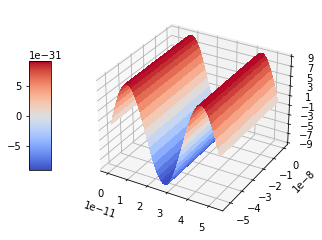

In [14]:
Estate = Ex2   # either Eground, Ex1, or Ex2 

graphWF(Estate)